## Pregunta: T1 - ¿Tiende a crecer el tamaño de las distribuciones a lo largo del tiempo?

### 1. Importaciones

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
import statsmodels.api as sm

from IPython.display import display, Markdown

### 2. Lectura

In [2]:
df = pd.read_csv("../../datawarehouse/processed-ubuntu-packages.csv")

### 3. Preprocesado

In [3]:
# only get where priority is important or required
df = df[df['Priority'].isin(['important', 'required'])]

# print head of dataframe
df.head()

,Distro-Version,Distro-Year,Package,Description,Section,Version,Architecture,Priority,Essential,Build-Essential,...,Original-Maintainer,Size,Installed-Size,Depends,Pre-Depends,Recommends,Conflicts,Suggests,Replaces,Provides
4,18.04 - bionic,2018,adduser,Description,admin,3.116ubuntu1,all,important,no,yes,...,Debian,162684.0,624.0,"passwd, debconf (>= 0.5) | debconf-2.0",NaN,"toshset, wireless-tools",uswsusp (<= 0.2),"liblocale-gettext-perl, perl, ecryptfs-utils (...",NaN,NaN
37,18.04 - bionic,2018,base-passwd,Description,admin,3.5.44,amd64,required,yes,yes,...,Debian,47236.0,228.0,"libc6 (>= 2.8), libdebconfclient0 (>= 0.145)",NaN,debconf (>= 0.5) | debconf-2.0,libfile-rsyncp-perl (<< 0.68),"w3m | www-browser, par2",base,"automake-1.15, automaken"
76,18.04 - bionic,2018,coreutils,Description,utils,8.28-1ubuntu1,amd64,required,yes,yes,...,Michael,1230832.0,6560.0,"libc6 (>= 2.14), libmnl0 (>= 1.0.3-4~), libnet...","libacl1 (>= 2.2.51-8), libattr1 (>= 1:2.4.46-8...",distro-info,lockfile-progs (<< 0.1.7),colord-sensor-argyll,colord (<< 1.2.0-2),debconf-2.0
86,18.04 - bionic,2018,dash,Description,shells,0.5.8-2.10,amd64,required,yes,yes,...,Gerrit,88544.0,214.0,"debianutils (>= 2.15), dpkg (>= 1.15.0)",libc6 (>= 2.14),wamerican | wordlist,qemu-kvm (<< 0.12.3-0ubuntu13),colord-sensor-argyll,qemu-kvm (<< 0.12.3-0ubuntu13),debconf-2.0
96,18.04 - bionic,2018,debianutils,Description,utils,4.8.4,amd64,required,yes,yes,...,Clint,85672.0,212.0,libc6 (>= 2.14),libc6 (>= 2.15),"apt, curl, dctrl-tools, elfutils, libipc-syste...","bikeshed, debget","apt-file, konqueror, libgnome2-bin, lsb-releas...","bikeshed, debget",grep-dctrl


### 4. Análisis de series de tiempo


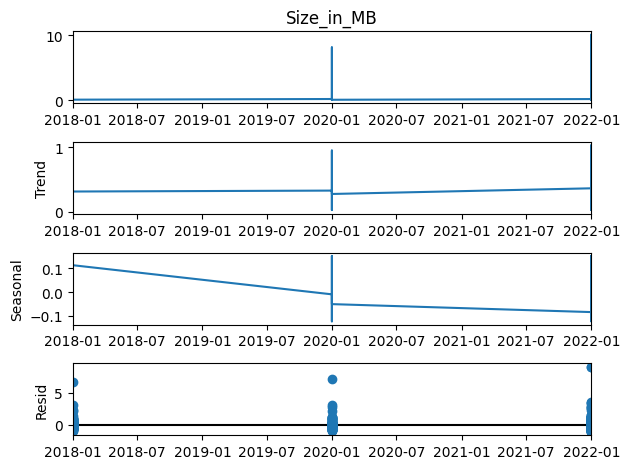

In [4]:
# Usaremos un análisis de series de tiempo para modelar la evolución del tamaño de las distribuciones a lo largo del tiempo

# Convierte la columna 'Distro-Year' en un objeto de fecha
df['Distro-Year'] = pd.to_datetime(df['Distro-Year'], format='%Y')

# Establece la columna 'Distro-Year' como el índice del DataFrame
df.set_index('Distro-Year', inplace=True)

# Ordena el índice en orden cronológico
df.sort_index(inplace=True)

# Crea una nueva columna para el tamaño de la distribución
df['Size_in_MB'] = df['Size'] / 1024 / 1024

# Crea una serie de tiempo con la columna 'Size_in_MB'
ts = df['Size_in_MB']

# Descomposición de la serie de tiempo
decomposition = sm.tsa.seasonal_decompose(ts, model='additive', period=12)

# Grafica la descomposición de la serie de tiempo
fig = decomposition.plot()

### 5. Regresión lineal


In [5]:
# Al realizar el análisis de series de tiempo hemos visto que no nos sirve de mucho, ya que solo tenemos info de los paquetes en 4 instantes de tiempo en nuestro csv
# Por ello, y viendo que tenemos una gráfica algo dispar, usaremos una regresión lineal para modelar la relación entre el tamaño de la distribución y el año. 
# Si el coeficiente de regresión es positivo, entonces hay una tendencia creciente en el tamaño de la distribución a lo largo del tiempo

# Read in the data and preprocess it
df = pd.read_csv("../../datawarehouse/processed-ubuntu-packages.csv")
df = df.replace("Null", np.nan)
df = df[df['Priority'].isin(['important', 'required'])]

# Add a column for package size in MB
df['SizeKB'] = df['Size'] / 1024

# Fit a linear regression model to the data
reg = LinearRegression().fit(df[['Distro-Year']], df['SizeKB'])

# Compute the p-value, R-squared, and RMSE
y_pred = reg.predict(df[['Distro-Year']])
slope, intercept, r_value, p_value, std_err = stats.linregress(df['Distro-Year'], df['SizeKB'])
r2 = r_value ** 2
rmse = np.sqrt(mean_squared_error(df['SizeKB'], y_pred))

# Print the regression coefficient, p-value
coef = reg.coef_[0]
print(f"Regression coefficient: {coef:.2f}")
print(f"P-value: {float(p_value):.2f}")


# Create the tick text
if coef > 0:
    tick_text = "<span style='color:green;font-size:30px'>&#10004;</span> \n The size of the distribution is increasing over time."
else:
    tick_text = "<span style='color:red;font-size:30px;line-height:0.5'>&#10006;</span> \n The size of the distribution is decreasing over time."

# Print the regression coefficient and the tick text
display(Markdown(f"Regression coefficient: {coef:.2f} {tick_text}"))

Regression coefficient: 19.64
P-value: 0.26


Regression coefficient: 19.64 <span style='color:green;font-size:30px'>&#10004;</span> 
 The size of the distribution is increasing over time.

El coeficiente de regresión indica que hay un aumento promedio de 19.64 KB en el tamaño de los paquetes por cada unidad adicional de tiempo en el eje x, que hablando de tamaño de paquetes es bastante.

El valor de p-value de 0.26 indica que la relación entre el tamaño de los paquetes y el tiempo no es estadísticamente significativa. Esto significa que no podemos rechazar la hipótesis nula de que el coeficiente de regresión es igual a cero y que la variación en el tamaño de los paquetes no está relacionada con el tiempo.